In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

## Check grades

In [4]:
df = pd.read_csv(r'../../data/tidy/large/trajectories-mapped-powertrain-weight-grade-oct2021-sep2022.csv', delimiter=',', skiprows=0, low_memory=False)

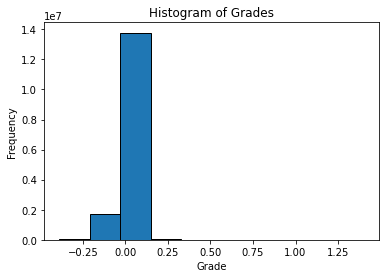

In [5]:
plt.hist(df['grade'], bins=10, edgecolor='black') 
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.title('Histogram of Grades')
plt.show()

## Check MPGs

### BEB

In [6]:
df = pd.read_csv(r'../../results/computed-fuel-rates-oct2021-sep2022-12212023.csv', delimiter=',', skiprows=0, low_memory=False)

In [7]:
validation_beb= pd.read_excel(r'../../data/tidy/BEB-validation.xlsx')

In [8]:
df_beb=df[df['Powertrain'] == 'electric'].copy()
df_cdb=df[df['Powertrain'] == 'conventional'].copy()
df_heb=df[df['Powertrain'] == 'hybrid'].copy()

In [9]:
# Convert date columns to datetime if they are not already
df_beb['Date'] = pd.to_datetime(df_beb['Date'])
validation_beb['Transaction Date'] = pd.to_datetime(validation_beb['Transaction Date'])

# Group by Date and Vehicle in df_beb and sum the Energy
grouped_energy = df_beb.groupby(['Date', 'Vehicle'])[['Energy', 'dist']].sum().reset_index()

# Merge the dataframes
merged_df = pd.merge(validation_beb, grouped_energy, 
                     left_on=['Transaction Date', 'Equipment ID'], 
                     right_on=['Date', 'Vehicle'], 
                     how='left')

In [10]:
# Drop rows where 'trip' or 'Predicted Energy' is NaN
merged_df = merged_df.dropna(subset=['trip', 'Energy'])

# Drop rows where 'trip' or 'Predicted Energy' is 0
merged_df = merged_df.query("trip != 0 and `Energy` != 0")
merged_df

,Equipment ID,trip,charge,Transaction Date,Date,Vehicle,Energy,dist
0,3501,26.7,35.0,2022-06-01,2022-06-01,3501.0,18.110245,15.759902
1,3501,167.1,182.7,2022-06-02,2022-06-02,3501.0,102.091546,96.860943
3,3501,173.9,166.1,2022-06-06,2022-06-06,3501.0,89.990138,97.573532
4,3501,74.3,180.0,2022-06-07,2022-06-07,3501.0,45.573762,44.192232
5,3501,81.4,108.5,2022-06-08,2022-06-08,3501.0,56.172659,43.615372
...,...,...,...,...,...,...,...,...
269,1321,141.5,0.8,2022-09-26,2022-09-26,1321.0,69.772779,88.931381
270,1321,139.1,390.0,2022-09-27,2022-09-27,1321.0,66.209468,63.968701
271,1321,194.8,3.1,2022-09-28,2022-09-28,1321.0,96.772027,102.720630
272,1321,116.0,387.8,2022-09-29,2022-09-29,1321.0,41.598193,42.246626


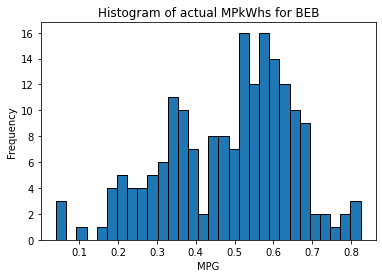

In [11]:
merged_df['actual_mpg']=merged_df['dist']/merged_df['trip']
merged_df['pred_mpg']=merged_df['dist']/merged_df['Energy']
plt.hist(merged_df['actual_mpg'], bins=30, edgecolor='black') 
plt.xlabel('MPG')
plt.ylabel('Frequency')
plt.title('Histogram of actual MPkWhs for BEB')
plt.show()

In [12]:
#merged_df=merged_df.loc[merged_df['charge']!=0]

In [13]:
from sklearn.model_selection import train_test_split

train_merged_df, test_merged_df = train_test_split(merged_df, test_size=0.2, random_state=42)

In [14]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute MAPE
mape = mean_absolute_percentage_error(test_merged_df['trip'], test_merged_df['Energy'])

# Compute RMSE
rmse = np.sqrt(mean_squared_error(test_merged_df['trip'], test_merged_df['Energy']))

print(f"MAPE: {mape:.2f}")
print(f"RMSE: {rmse:.2f}")

MAPE: 0.45
RMSE: 72.61


In [12]:
#df_cdb.loc[df_cdb['power']>20000]
#df_heb.loc[df_heb['power']>20000]
#df_beb.loc[df_beb['power']>20000]

In [13]:
#df_cdb=df_cdb.loc[df_cdb['power']<20000]
#df_heb=df_heb.loc[df_heb['power']<20000]
#df_beb=df_beb.loc[df_beb['power']<20000]

In [20]:
###df_cdb=df_cdb.loc[df_cdb['dist']>0]
###df_heb=df_heb.loc[df_heb['dist']>0]
###df_beb=df_beb.loc[df_beb['dist']>0]

In [38]:
# Finding the actual indices of 'power' zero and 'Acceleration' not zero
zero_power_nonzero_accel_indices = [idx for idx, (pwr, accel) in enumerate(zip(df_cdb['power'], df_cdb['Acceleration'])) if pwr == 0 and accel != 0]

# Initialize a set for all indices to include (unique values only)
indices_to_include = set()

# Loop through each identified index and add it and up to two valid preceding indices
for idx in zero_power_nonzero_accel_indices:
    # Add the actual index of zero power and nonzero acceleration
    indices_to_include.add(sorted_index[idx])

    # Try to add one preceding index if it exists
    if idx - 1 >= 0:
        indices_to_include.add(sorted_index[idx - 1])

    # Try to add two preceding indices if it exists
    if idx - 2 >= 0:
        indices_to_include.add(sorted_index[idx - 2])

# Ensure the indices are sorted and then use them to filter the DataFrame
filtered_df = df_cdb.loc[sorted(indices_to_include)]

# Displaying a portion of the resulting DataFrame for brevity
filtered_df


,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ServiceDateTime,DateKey,CalendarDate,Year,Month,...,VehicleModel,Vehicle_mass,time_delta_in_seconds,dist,Speed,Acceleration,elevation,grade,power,Energy
124,124,124,1365952,1365952,1365952,2021-10-01 10:51:23,8578,2021-10-01 00:00:00.000,2021,10,...,Gillig 30,25700,179,0.295655,2.658161,-0.000794,66.0,0.031528,12.357944,0.151560
125,125,125,1365953,1365953,1365953,2021-10-01 10:56:08,8578,2021-10-01 00:00:00.000,2021,10,...,Gillig 30,25700,285,0.005855,0.033063,-0.005723,66.0,0.000000,0.020348,0.130658
126,126,126,1365954,1365954,1365954,2021-10-01 10:58:56,8578,2021-10-01 00:00:00.000,2021,10,...,Gillig 30,25700,168,0.000000,0.000000,-0.000122,66.0,0.000000,0.000000,0.076912
155,155,155,1365984,1365984,1365984,2021-10-01 11:53:47,8578,2021-10-01 00:00:00.000,2021,10,...,Gillig 30,25700,80,0.295655,5.947636,0.015952,66.0,0.031528,31.293278,0.115532
156,156,156,1365985,1365985,1365985,2021-10-01 11:55:37,8578,2021-10-01 00:00:00.000,2021,10,...,Gillig 30,25700,110,0.005855,0.085663,-0.033113,66.0,0.000000,0.017646,0.050420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15469852,15472172,15472172,15352052,15352052,15352052,2022-09-26 13:50:24,8938,2022-09-26 00:00:00.000,2022,9,...,NEW FLYER XD40,28250,13,0.112362,13.909924,0.375062,41.0,0.011056,150.872030,0.068391
15469853,15472173,15472173,15352053,15352053,15352053,2022-09-26 13:51:17,8938,2022-09-26 00:00:00.000,2022,9,...,NEW FLYER XD40,28250,53,0.107303,3.258265,-0.124880,40.0,-0.005789,-6.847316,0.024264
15470587,15472908,15472908,15567727,15567727,15567727,2022-09-30 09:59:52,8942,2022-09-30 00:00:00.000,2022,9,...,NEW FLYER XD40,28250,71,0.249161,5.647682,-0.043401,46.0,0.007479,8.030179,0.050440
15470588,15472909,15472909,15567728,15567728,15567728,2022-09-30 10:01:11,8942,2022-09-30 00:00:00.000,2022,9,...,NEW FLYER XD40,28250,79,0.219645,4.474484,-0.009228,49.0,0.008484,9.060712,0.058686


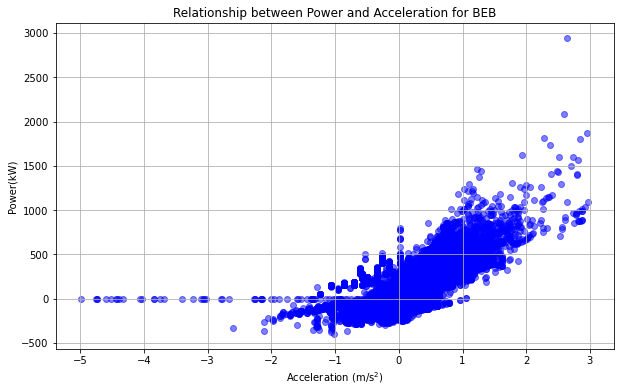

In [37]:
# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df_beb['Acceleration'],df_beb['power'], color='blue', alpha=0.5)
plt.title('Relationship between Power and Acceleration for BEB')
plt.xlabel(r'Acceleration (m/s$^2$)')
plt.ylabel('Power(kW)')
plt.grid(True)
plt.show()

In [27]:
#df_beb.loc[df_beb['Acceleration']<-3]

In [28]:
df_cdb.loc[df_cdb['power']>30000]

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ServiceDateTime,DateKey,CalendarDate,Year,Month,...,VehicleModel,Vehicle_mass,time_delta_in_seconds,dist,Speed,Acceleration,elevation,grade,power,Energy
9386617,9387152,9387152,3138491,3138491,3138491,2021-11-08 15:40:39,8616,2021-11-08 00:00:00.000,2021,11,...,NEW FLYER XD40,28250,74,7.459224,162.222401,1.339787,85.0,0.001915,34368.806732,310.898677
9386618,9387153,9387153,3138466,3138466,3138466,2021-11-08 15:41:15,8616,2021-11-08 00:00:00.000,2021,11,...,NEW FLYER XD40,28250,36,6.999998,312.927906,2.601226,72.0,-0.001154,232429.425285,5400.796118
9386633,9387168,9387168,3138480,3138480,3138480,2021-11-08 16:08:17,8616,2021-11-08 00:00:00.000,2021,11,...,NEW FLYER XD40,28250,61,6.485929,171.116248,1.668396,86.0,0.000096,40738.510174,345.589658


In [29]:
df_cdb=df_cdb.loc[df_cdb['power']<30000]

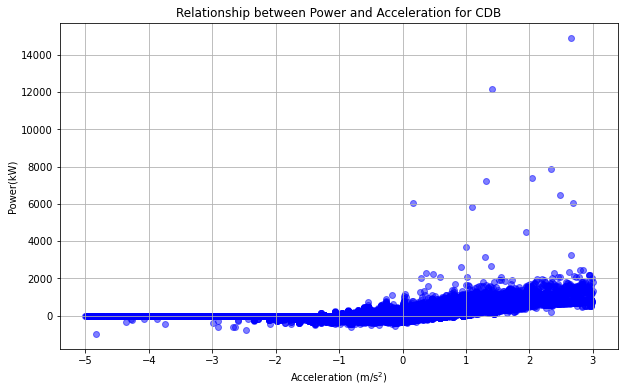

In [35]:
# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df_cdb['Acceleration'],df_cdb['power'], color='blue', alpha=0.5)
plt.title('Relationship between Power and Acceleration for CDB')
plt.xlabel(r'Acceleration (m/s$^2$)')
plt.ylabel('Power(kW)')
plt.grid(True)
plt.show()

In [31]:
df_heb.loc[df_heb['power']>10000]

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ServiceDateTime,DateKey,CalendarDate,Year,Month,...,VehicleModel,Vehicle_mass,time_delta_in_seconds,dist,Speed,Acceleration,elevation,grade,power,Energy
6454439,6454837,6454837,3139979,3139979,3139979,2021-11-08 09:10:19,8616,2021-11-08 00:00:00.000,2021,11,...,NEW FLYER XDE40,28250,47,6.212168,212.713102,2.696225,20.0,-0.004899,83519.906173,958.402386
6454440,6454838,6454838,3140232,3140232,3140232,2021-11-08 09:11:12,8616,2021-11-08 00:00:00.000,2021,11,...,NEW FLYER XDE40,28250,53,6.065792,184.187674,-0.334432,77.0,0.005837,46915.022908,366.646795
6454444,6454842,6454842,3139981,3139981,3139981,2021-11-08 09:14:07,8616,2021-11-08 00:00:00.000,2021,11,...,NEW FLYER XDE40,28250,64,4.786467,120.360502,1.016915,26.0,-0.005840,15565.830994,64.409503
6454474,6454873,6454873,3140260,3140260,3140260,2021-11-08 09:32:29,8616,2021-11-08 00:00:00.000,2021,11,...,NEW FLYER XDE40,28250,51,4.762854,150.295491,1.735923,33.0,-0.004956,30644.461887,163.283485


In [32]:
df_heb=df_heb.loc[df_heb['power']<10000]

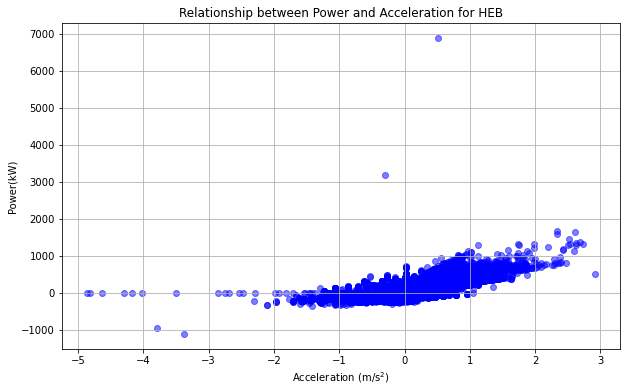

In [36]:
# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df_heb['Acceleration'],df_heb['power'], color='blue', alpha=0.5)
plt.title('Relationship between Power and Acceleration for HEB')
plt.xlabel(r'Acceleration (m/s$^2$)')
plt.ylabel('Power(kW)')
plt.grid(True)
plt.show()

In [59]:
# Calculate Absolute Percentage Error (APE) for each row
merged_df['APE'] = (abs(merged_df['trip'] - merged_df['Energy']) / merged_df['trip']) * 100
top_20_mape = merged_df.nlargest(20, 'APE')
top_20_mape

C:\Users\Mahsa\AppData\Local\Temp\ipykernel_30256\1555797160.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['APE'] = (abs(merged_df['trip'] - merged_df['Energy']) / merged_df['trip']) * 100


,Equipment ID,trip,charge,Transaction Date,Date,Vehicle,Energy,dist,actual_mpg,pred_mpg,APE
213,1321,89.8,154.6,2022-05-18,2022-05-18,1321.0,4.641519,3.577301,0.039836,0.770718,94.831270
211,1323,15.4,17.5,2022-05-16,2022-05-16,1323.0,0.931696,0.626032,0.040651,0.671928,93.950029
64,1323,23.0,22.0,2022-04-25,2022-04-25,1323.0,2.602497,6.098154,0.265137,2.343194,88.684797
160,1421,21.0,50.6,2022-06-09,2022-06-09,1421.0,2.926038,4.184522,0.199263,1.430098,86.066487
11,3501,205.7,101.2,2022-06-15,2022-06-15,3501.0,28.719858,70.551210,0.342981,2.456531,86.037988
63,1323,85.1,103.8,2022-04-21,2022-04-21,1323.0,12.283193,14.524731,0.170678,1.182488,85.566166
26,3501,208.9,66.3,2022-07-06,2022-07-06,3501.0,33.657181,70.524544,0.337600,2.095379,83.888377
83,1420,180.8,1.3,2022-08-25,2022-08-25,1420.0,29.195314,51.784133,0.286417,1.773714,83.852149
71,1421,201.7,0.7,2022-08-05,2022-08-05,1421.0,33.945878,56.042432,0.277850,1.650935,83.170115
15,3501,202.9,99.2,2022-06-22,2022-06-22,3501.0,37.455001,70.551210,0.347714,1.883626,81.540167


### HEB

In [102]:
validation_heb = pd.read_csv(r'../../results/validation-vs-computed-fuel-rates-clean-heb-oct2021-sep2022-12212023.csv', delimiter=',', skiprows=0, low_memory=False)

In [103]:
validation_heb['actual_mpg']=validation_heb['dist']/validation_heb['Qty']
validation_heb['pred_mpg']=validation_heb['dist']/validation_heb['Energy']

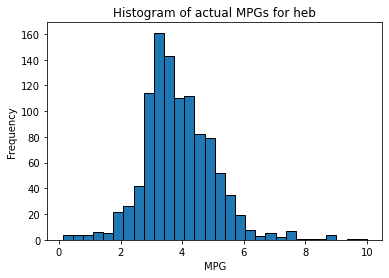

In [104]:
plt.hist(validation_heb['actual_mpg'], bins=30, edgecolor='black') 
plt.xlabel('MPG')
plt.ylabel('Frequency')
plt.title('Histogram of actual MPGs for heb')
plt.show()

In [105]:
# Calculate the 1st and 99th percentiles
percentile_5 = validation_heb['actual_mpg'].quantile(0.05)
percentile_95 = validation_heb['actual_mpg'].quantile(0.95)

# Filter the DataFrame
trimmed_validation_heb = validation_heb[(validation_heb['pred_mpg'] >= percentile_5) & (validation_heb['pred_mpg'] <= percentile_95)]
trimmed_validation_heb = trimmed_validation_heb[(trimmed_validation_heb['actual_mpg'] >= percentile_5) & (trimmed_validation_heb['actual_mpg'] <= percentile_95)]

In [117]:
train_df_heb_vehicle, test_df_heb_vehicle = train_test_split(trimmed_validation_heb, test_size=0.2, random_state=42)

In [107]:
# Compute MAPE
mape = mean_absolute_percentage_error(test_df_heb_vehicle['Qty'], test_df_heb_vehicle['Energy'])

# Compute RMSE
rmse = np.sqrt(mean_squared_error(test_df_heb_vehicle['Qty'], test_df_heb_vehicle['Energy']))

print(f"MAPE: {mape:.2f}")
print(f"RMSE: {rmse:.2f}")

MAPE: 0.19
RMSE: 7.35


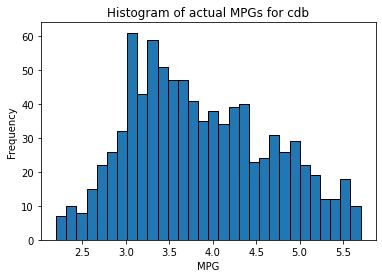

In [108]:
plt.hist(trimmed_validation_heb['actual_mpg'], bins=30, edgecolor='black') 
plt.xlabel('MPG')
plt.ylabel('Frequency')
plt.title('Histogram of actual MPGs for cdb')
plt.show()

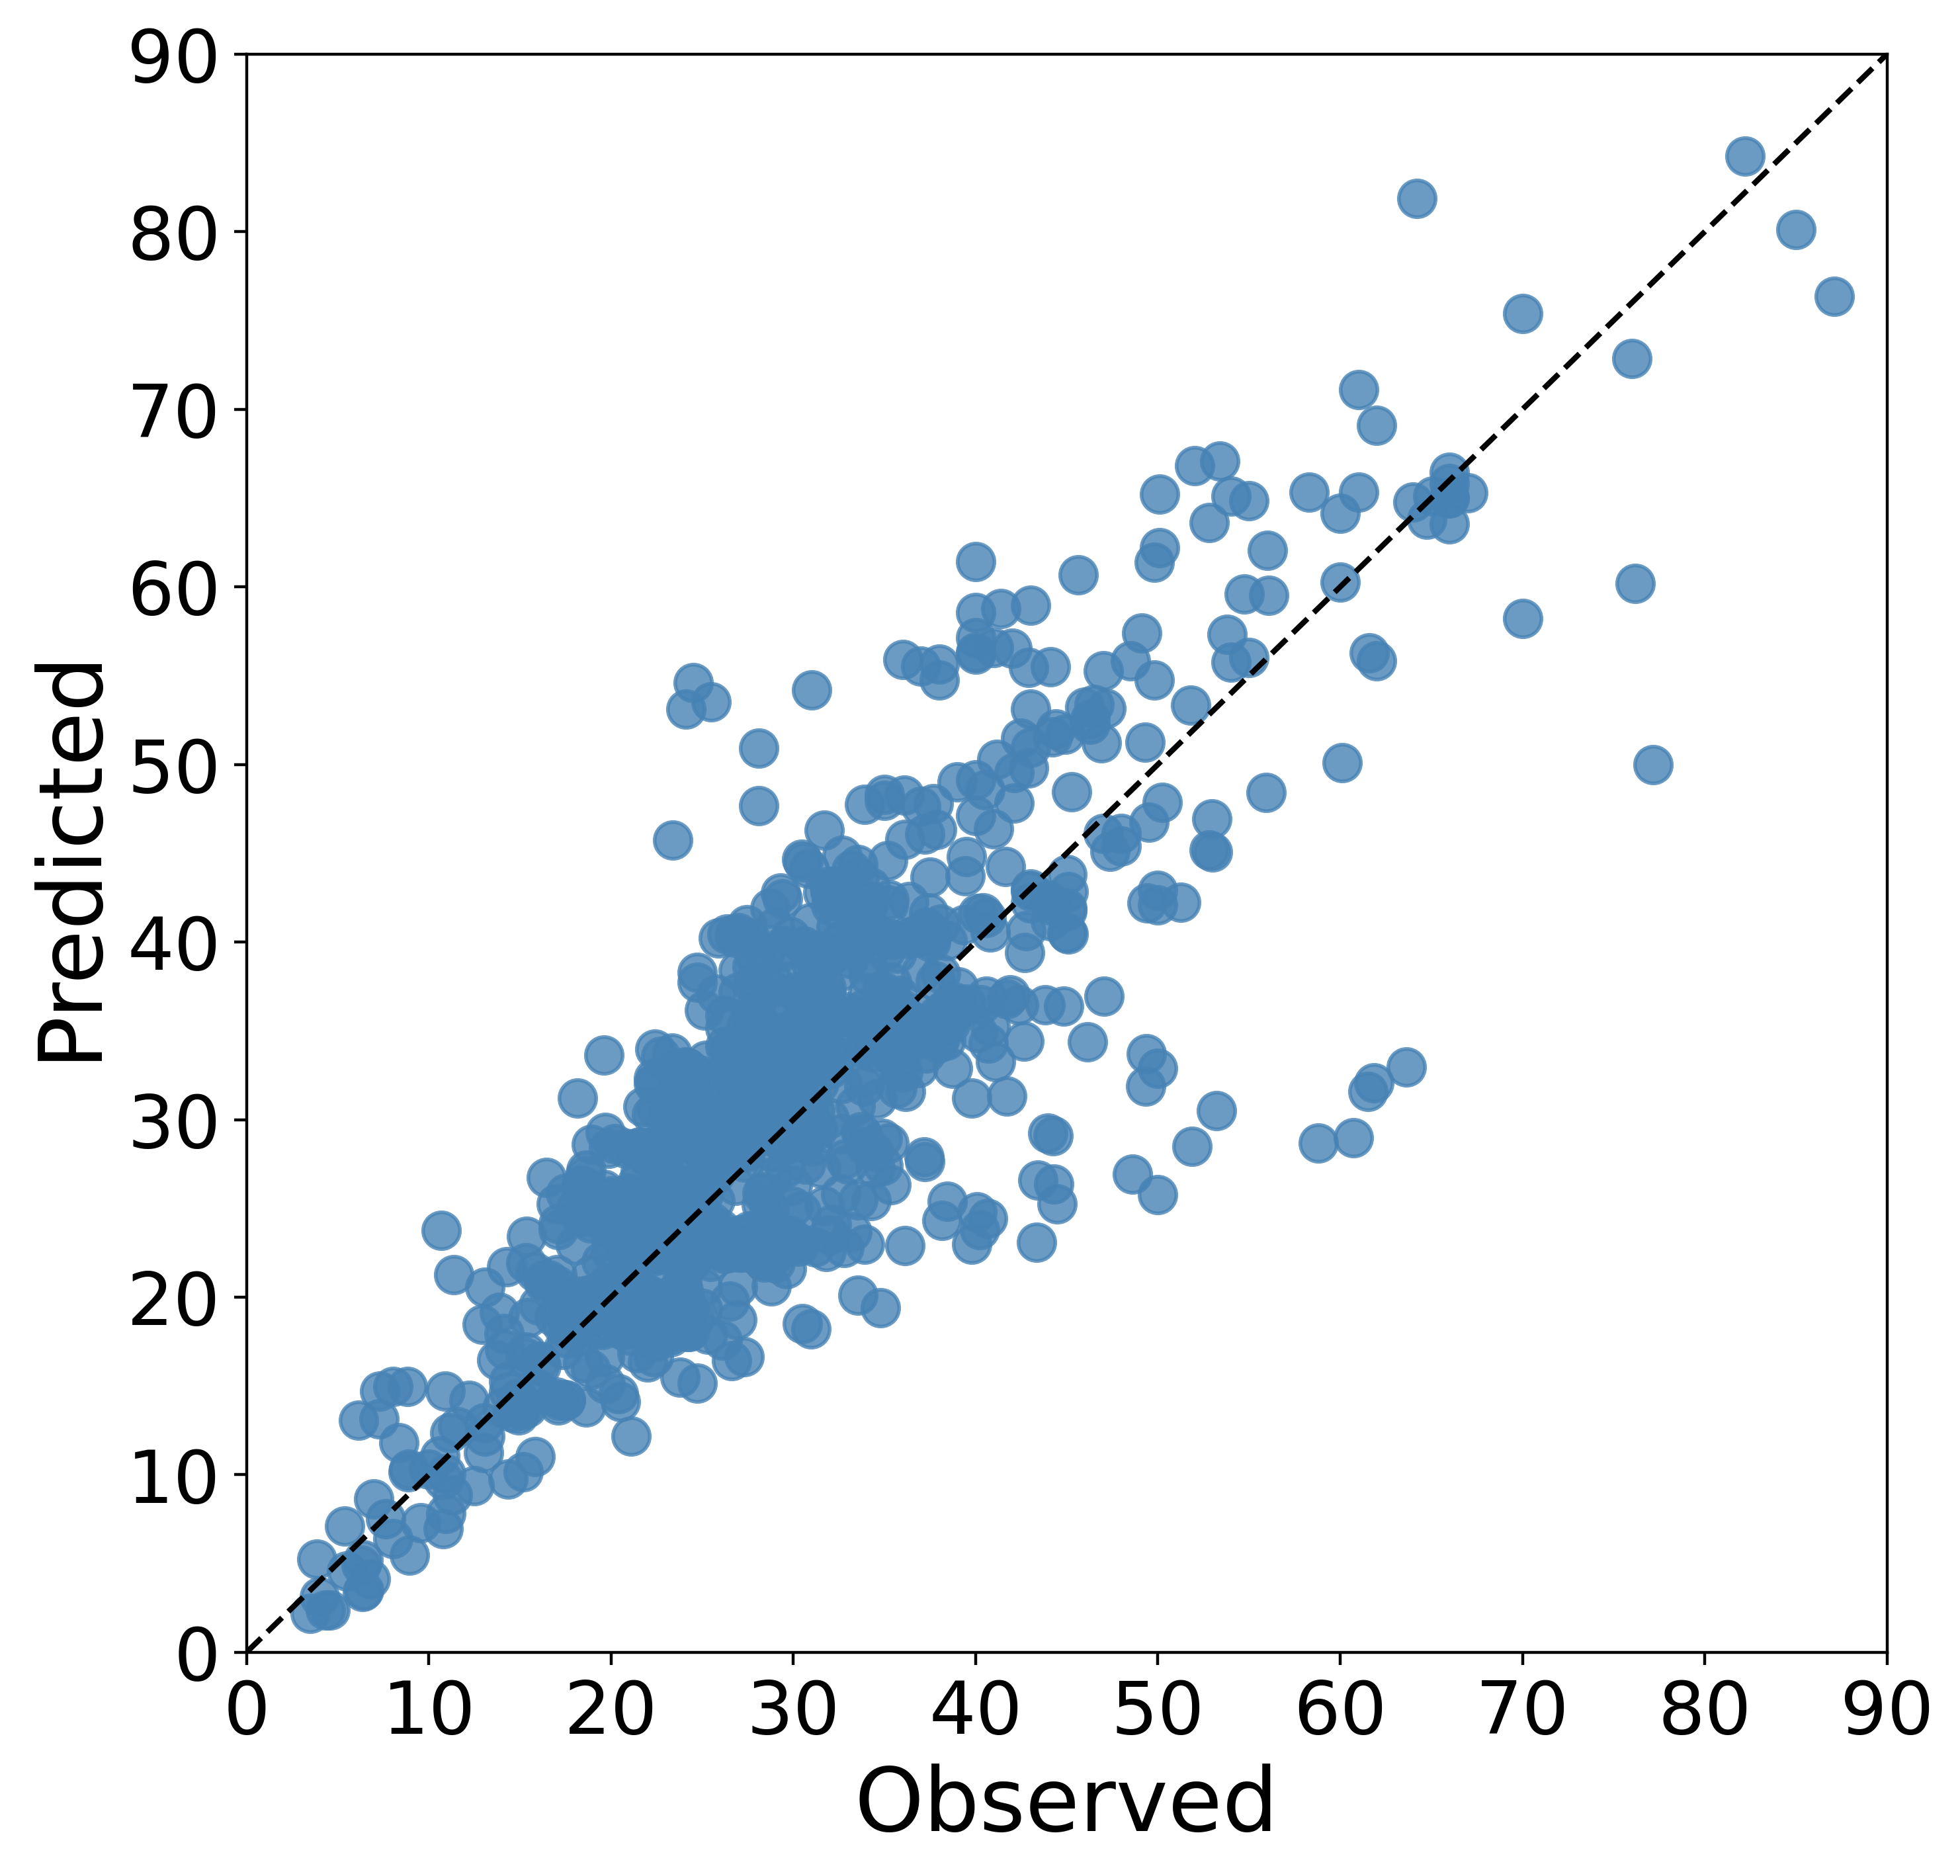

In [109]:
# create a new figure with specified size and DPI
fig = plt.figure(figsize=(8, 8), dpi=400)

# create a scatter plot of predicted vs observed
plt.scatter(trimmed_validation_heb['Qty'], trimmed_validation_heb['Energy'], alpha=0.8, s=100, color='steelblue')

# set the axis limits to 90
xlim = ylim = (0, 90)
plt.xlim(xlim)
plt.ylim(ylim)

# add a reference line showing perfect agreement between predicted and observed values
plt.plot(xlim, ylim, color='black', linestyle='dashed')

# set the axis labels
plt.ylabel('Predicted', fontsize=24)
plt.xlabel('Observed', fontsize=24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# show the plot
plt.show()

In [110]:
trimmed_validation_heb['ServiceDateTime'] = pd.to_datetime(trimmed_validation_heb['ServiceDateTime'])
trimmed_validation_heb = trimmed_validation_heb.set_index('ServiceDateTime')
weekly_energy_heb = trimmed_validation_heb[['Energy','Qty']].resample('W').sum()
weekly_energy_heb=weekly_energy_heb.reset_index()

In [115]:
train_df_heb_system, test_df_heb_system = train_test_split(weekly_energy_heb, test_size=0.2, random_state=42)

In [116]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute MAPE
mape = mean_absolute_percentage_error(test_df_heb_system['Qty'], test_df_heb_system['Energy'])

# Compute RMSE
rmse = np.sqrt(mean_squared_error(test_df_heb_system['Qty'], test_df_heb_system['Energy']))

print(f"MAPE: {mape:.2f}")
print(f"RMSE: {rmse:.2f}")

MAPE: 0.05
RMSE: 42.44


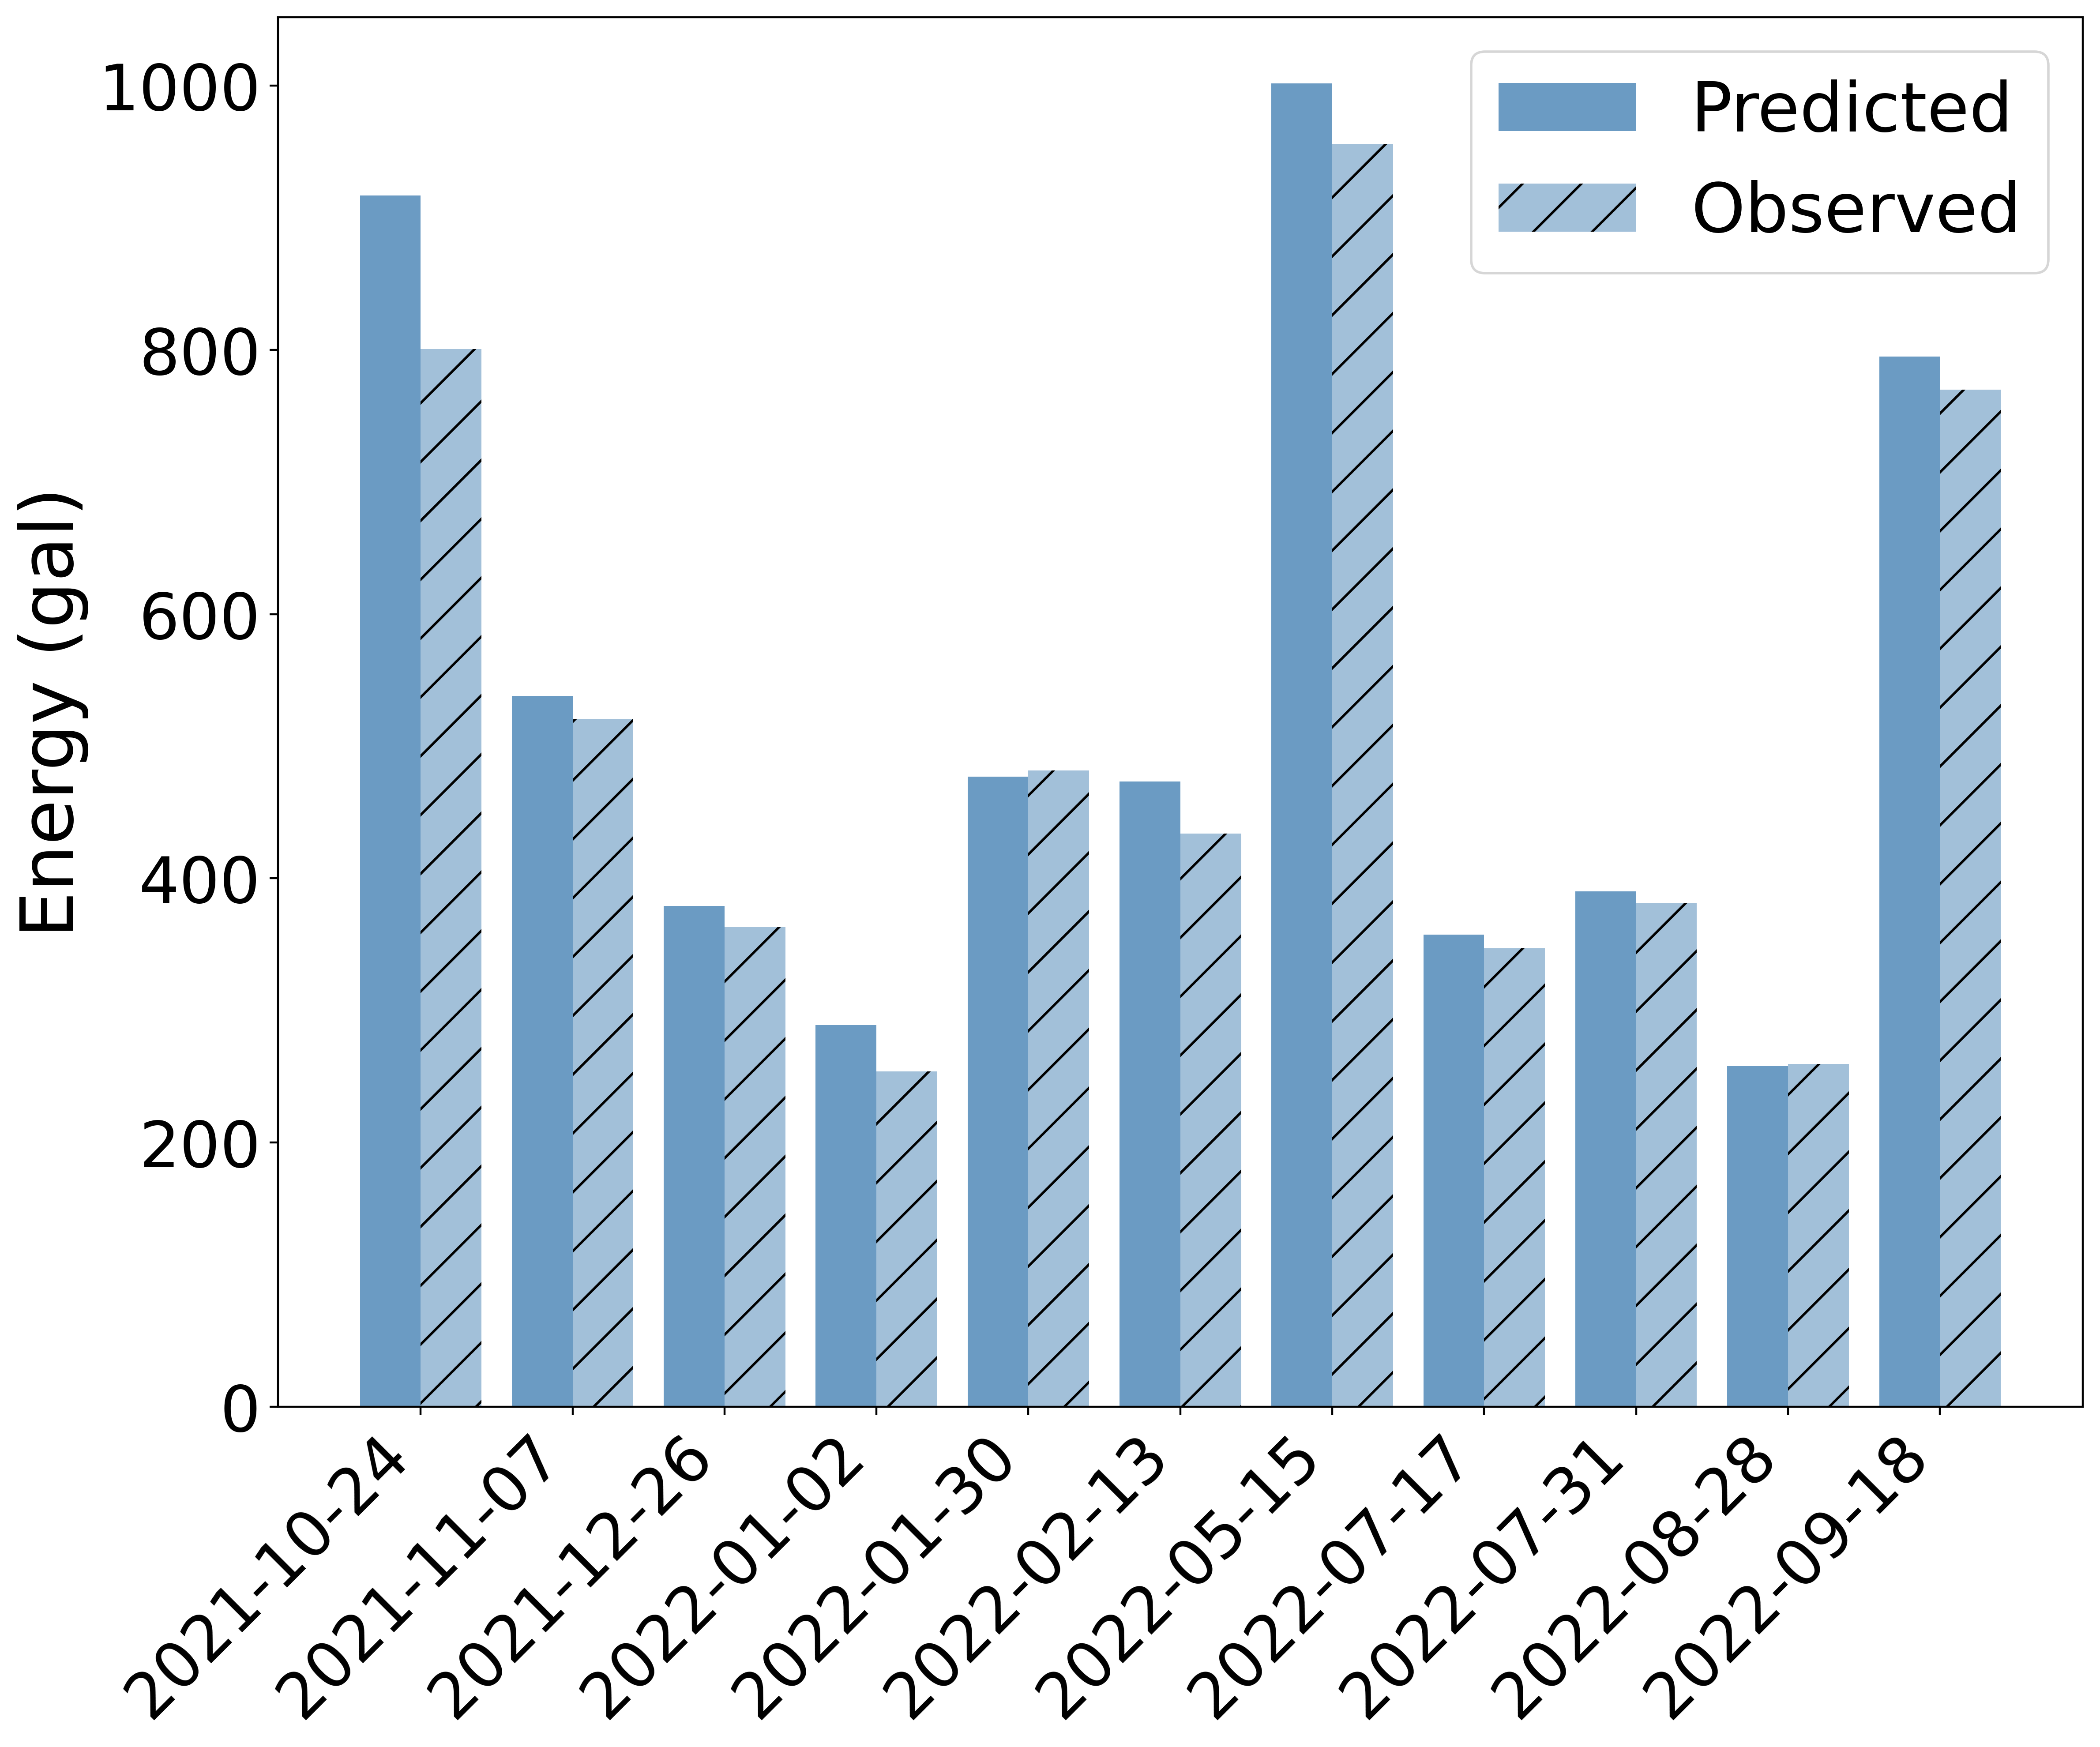

In [88]:
# Ensure 'ServiceDateTime' is a datetime object
test_df_heb_system['ServiceDateTime'] = pd.to_datetime(test_df_heb_system['ServiceDateTime'])
test_df_heb_system = test_df_heb_system.sort_values('ServiceDateTime')


# Set 'ServiceDateTime' as index for plotting purposes
test_df_heb_system.set_index('ServiceDateTime', inplace=True)

# Create an array with the position of each bar along the x-axis
x = np.arange(len(test_df_heb_system))

# Set the width of the bars
bar_width = 0.4

plt.figure(figsize=(12, 10), dpi=400)

# Plot 'Predicted' bars
plt.bar(x - bar_width/2, test_df_heb_system['Energy'], width=bar_width, color='steelblue', alpha=0.8, label='Predicted')

# Plot 'Observed' bars
plt.bar(x + bar_width/2, test_df_heb_system['Qty'], width=bar_width, color='steelblue', alpha=0.5, hatch='/', label='Observed')

# Put the x-axis labels (ServiceDateTime) using the index values
plt.xticks(x, test_df_heb_system.index.strftime('%Y-%m-%d'), rotation=45, ha='right', fontsize=26)
plt.yticks(fontsize=26)


plt.ylabel('Energy (gal)', fontsize=30)
plt.legend(fontsize=28)
plt.tight_layout()

# Save the figure with high resolution
plt.savefig(r'../../figures/validation-HEB-Oct2021-Sep2022.png', dpi=400, bbox_inches='tight')
plt.show()


### CDB

In [89]:
validation_cdb = pd.read_csv(r'../../results/validation-vs-computed-fuel-rates-clean-cdb-oct2021-sep2022-12212023.csv', delimiter=',', skiprows=0, low_memory=False)

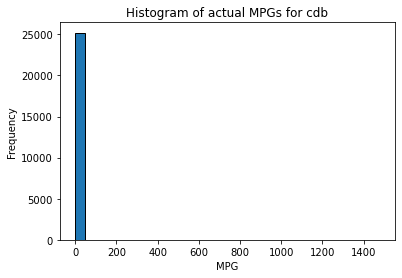

In [90]:
validation_cdb['actual_mpg']=validation_cdb['dist']/validation_cdb['Qty']
validation_cdb['pred_mpg']=validation_cdb['dist']/validation_cdb['Energy']
plt.hist(validation_cdb['actual_mpg'], bins=30, edgecolor='black') 
plt.xlabel('MPG')
plt.ylabel('Frequency')
plt.title('Histogram of actual MPGs for cdb')
plt.show()

In [91]:
# Calculate the 5st and 95th percentiles
percentile_5 = validation_cdb['actual_mpg'].quantile(0.05)
percentile_95 = validation_cdb['actual_mpg'].quantile(0.95)

# Filter the DataFrame
trimmed_validation_cdb = validation_cdb[(validation_cdb['pred_mpg'] >= percentile_5) & (validation_cdb['pred_mpg'] <= percentile_95)]
trimmed_validation_cdb = trimmed_validation_cdb[(trimmed_validation_cdb['actual_mpg'] >= percentile_1) & (trimmed_validation_cdb['actual_mpg'] <= percentile_99)]

In [92]:
top_150_actual_mpg = trimmed_validation_cdb.nlargest(150, 'actual_mpg')
top_150_actual_mpg

,Unnamed: 0,index,Vehicle,Qty,ServiceDateTime,Meter1Reading,Fuel Orfluid Type,Powertrain,dist,Energy,actual_mpg,pred_mpg
10168,10597,26105,1719,8.95,2022-09-15 22:00:00,92548,DIE,conventional,67.440451,21.681221,7.535246,3.110547
926,962,5545,1561,2.56,2021-11-02 22:11:00,424129,DIE,conventional,19.191761,5.989971,7.496782,3.203983
10487,10939,19808,1721,5.63,2021-12-28 18:47:00,24858,DIE,conventional,42.180667,12.536450,7.492126,3.364642
10327,10774,18355,1720,21.06,2022-06-12 19:13:00,76447,DIE,conventional,157.230944,43.930668,7.465857,3.579070
16898,17640,15817,1843,9.91,2022-01-15 17:51:00,254422,DIE,conventional,73.536557,23.555788,7.420440,3.121804
...,...,...,...,...,...,...,...,...,...,...,...,...
5606,5889,9253,1656,3.30,2021-10-30 18:45:00,281292,DIE,conventional,20.132304,4.750751,6.100698,4.237710
11944,12451,27485,1728,35.33,2022-07-26 22:36:00,16837,DIE,conventional,215.257421,63.380341,6.092766,3.396281
1537,1603,6989,1566,24.99,2022-01-02 20:03:00,361535,DIE,conventional,152.242552,40.913593,6.092139,3.721075
10324,10771,18352,1720,10.48,2022-06-09 21:58:00,76047,DIE,conventional,63.831638,34.156935,6.090805,1.868775


In [93]:
low_200_actual_mpg = trimmed_validation_cdb.nsmallest(200, 'actual_mpg')
low_200_actual_mpg

,Unnamed: 0,index,Vehicle,Qty,ServiceDateTime,Meter1Reading,Fuel Orfluid Type,Powertrain,dist,Energy,actual_mpg,pred_mpg
6446,6764,23581,1661,13.15,2022-08-02 15:19:00,193552,DIE,conventional,13.538437,4.962457,1.029539,2.728172
17895,18748,25583,1849,16.58,2022-07-06 21:36:00,282030,DIE,conventional,17.187709,6.006727,1.036653,2.861410
1656,1723,22628,1566,44.18,2022-08-31 17:35:00,389172,DIE,conventional,45.823210,13.340169,1.037194,3.434980
16619,17347,25285,1841,49.46,2022-07-01 22:35:00,273247,DIE,conventional,51.544331,17.799663,1.042142,2.895804
14202,14807,12791,1824,5.81,2021-12-17 15:45:00,315959,DIE,conventional,6.058513,1.730627,1.042773,3.500762
...,...,...,...,...,...,...,...,...,...,...,...,...
17515,18355,16366,1847,3.38,2022-03-11 15:56:00,254786,DIE,conventional,4.308640,1.359537,1.274746,3.169197
7906,8274,14439,1710,33.00,2021-10-04 19:34:00,215826,DIE,conventional,42.084884,15.739953,1.275300,2.673762
14643,15267,24588,1826,5.45,2022-09-12 16:22:00,0,DIE,conventional,6.950462,2.093584,1.275314,3.319886
16627,17355,25293,1841,16.84,2022-07-14 17:56:00,274424,DIE,conventional,21.481567,7.420108,1.275628,2.895048


In [94]:
train_df_cdb_vehicle, test_df_cdb_vehicle = train_test_split(trimmed_validation_cdb, test_size=0.2, random_state=42)

In [95]:
# Compute MAPE
mape = mean_absolute_percentage_error(test_df_cdb_vehicle['Qty'], test_df_cdb_vehicle['Energy'])

# Compute RMSE
rmse = np.sqrt(mean_squared_error(test_df_cdb_vehicle['Qty'], test_df_cdb_vehicle['Energy']))

print(f"MAPE: {mape:.2f}")
print(f"RMSE: {rmse:.2f}")

MAPE: 0.23
RMSE: 9.29


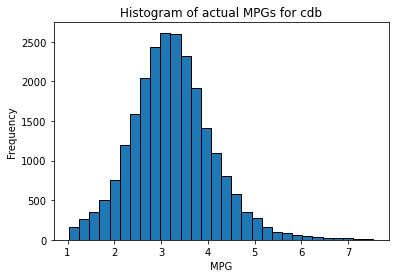

In [96]:
plt.hist(trimmed_validation_cdb['actual_mpg'], bins=30, edgecolor='black') 
plt.xlabel('MPG')
plt.ylabel('Frequency')
plt.title('Histogram of actual MPGs for cdb')
plt.show()

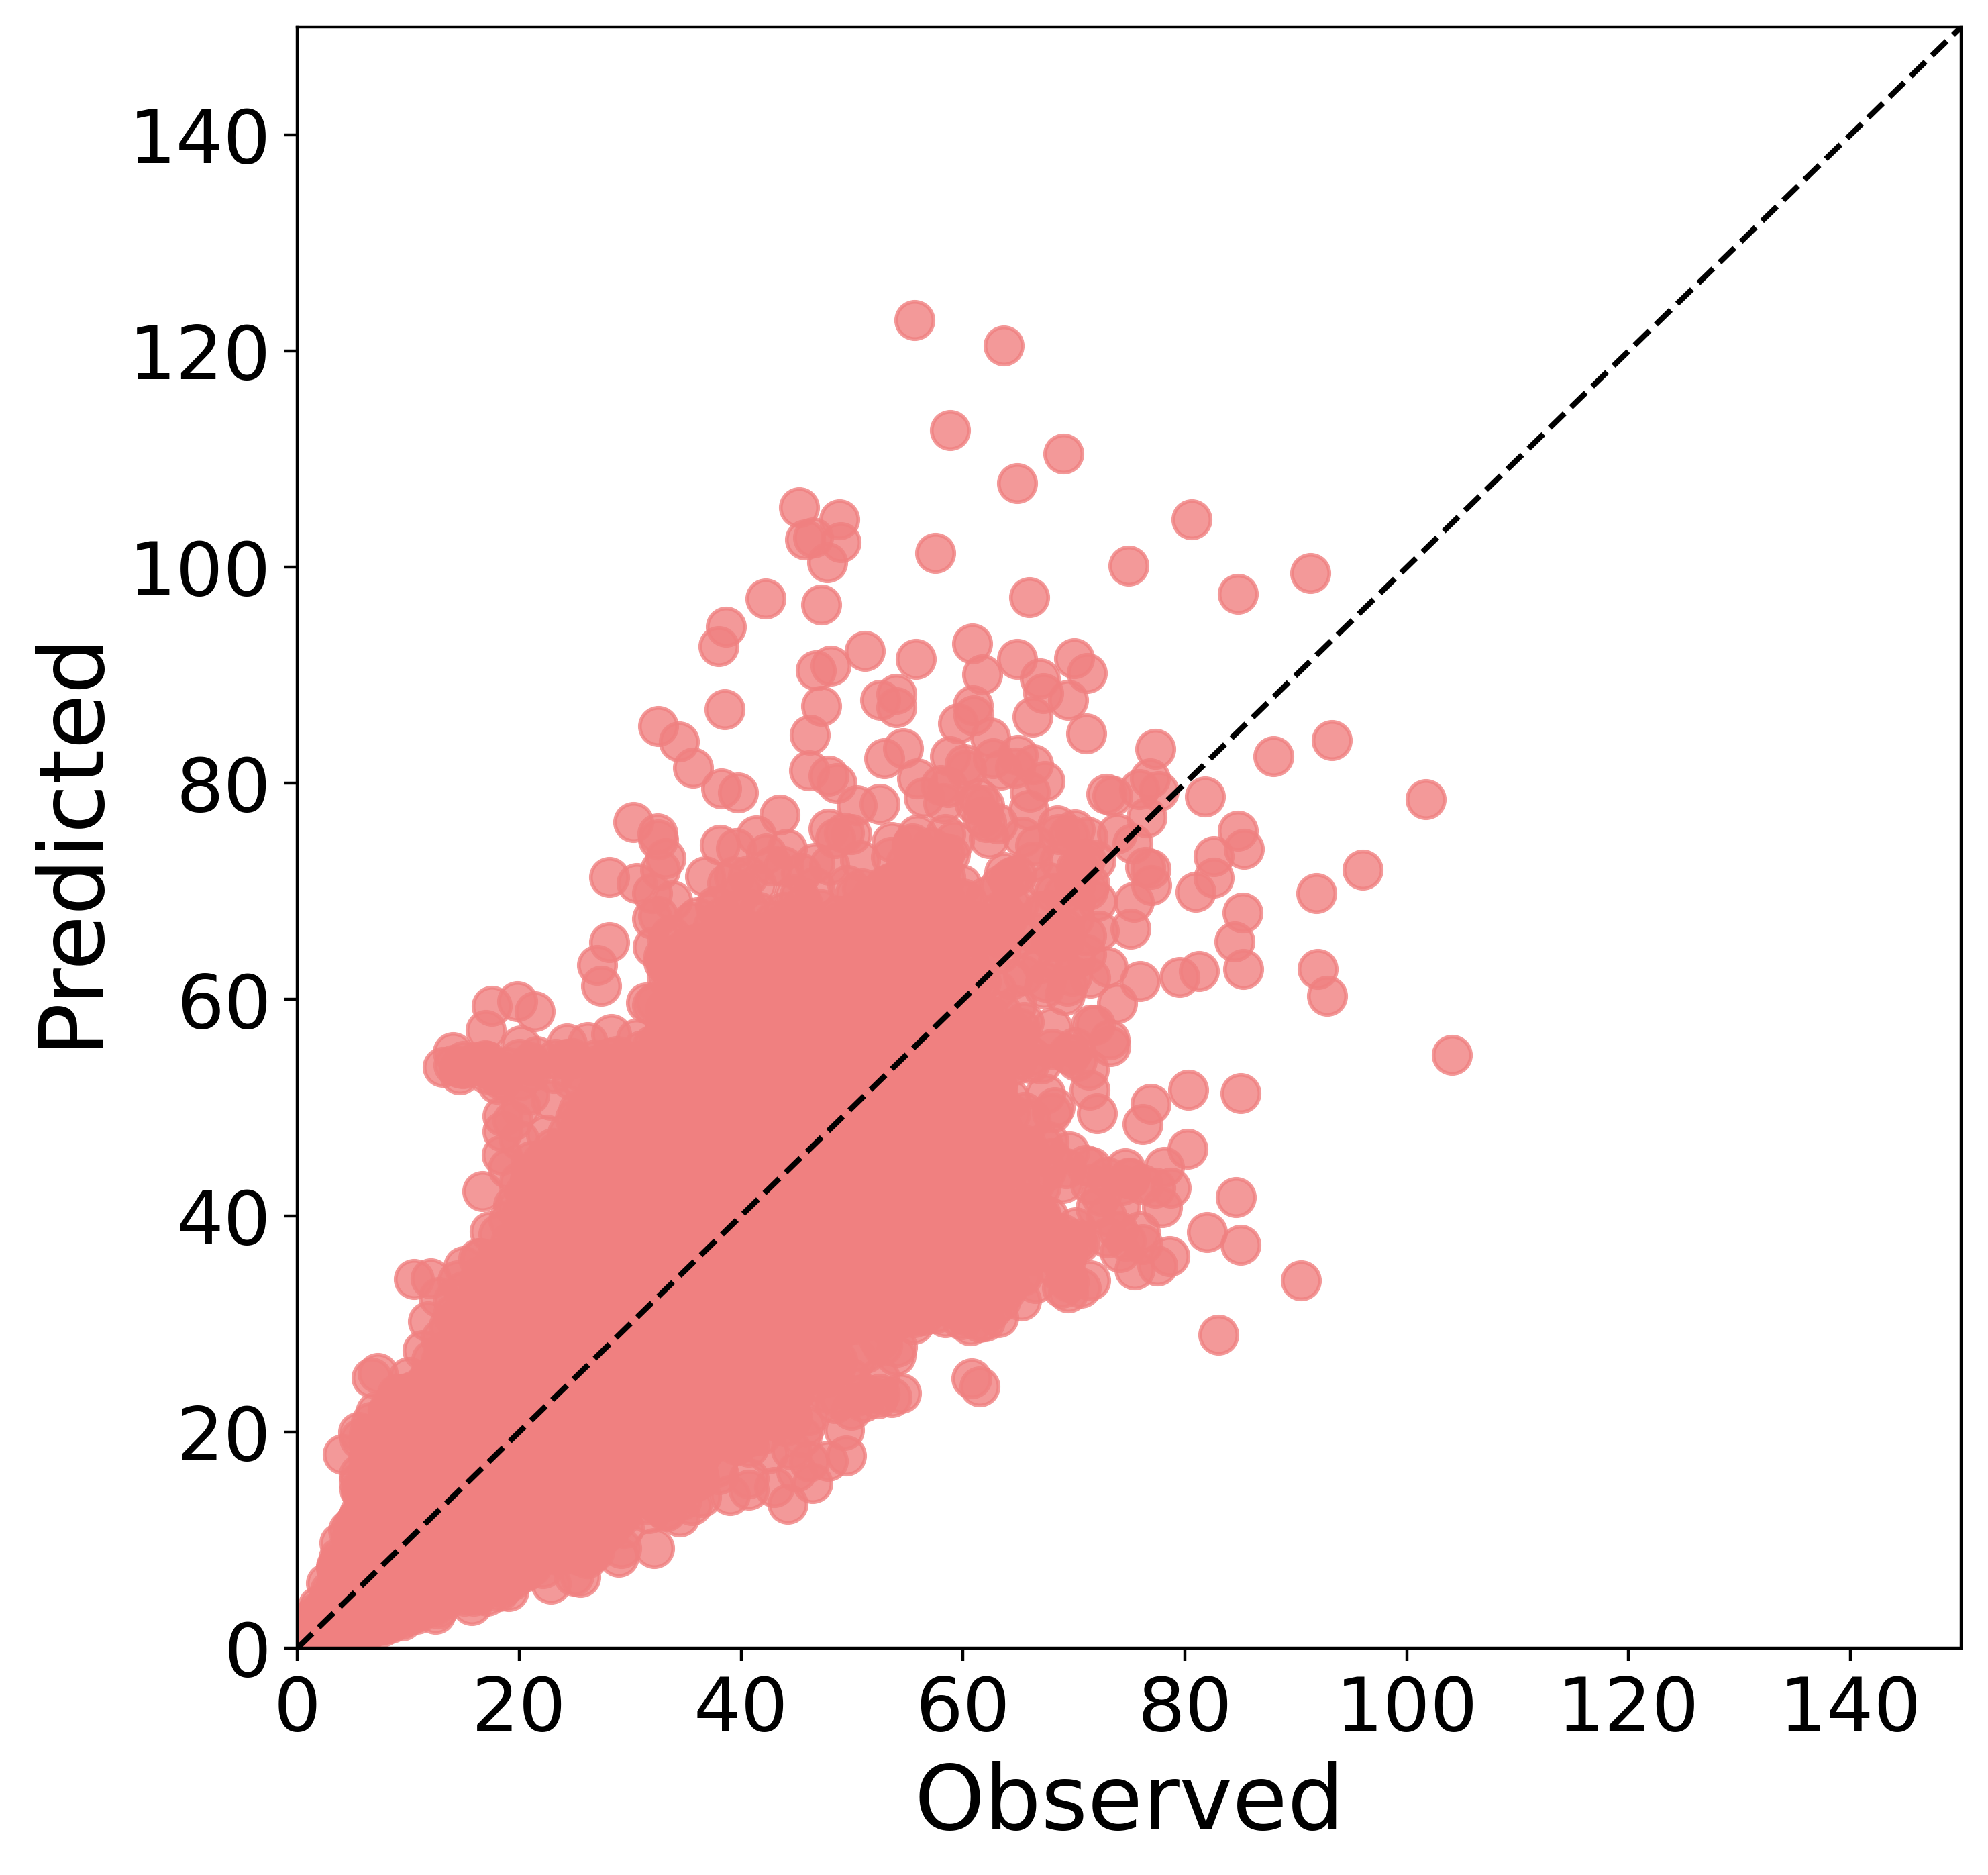

In [97]:
# create a new figure with specified size and DPI
fig = plt.figure(figsize=(8, 8), dpi=400)

# create a scatter plot of predicted vs observed
plt.scatter(trimmed_validation_cdb['Qty'], trimmed_validation_cdb['Energy'], alpha=0.8, s=100, color='lightcoral')

# Calculate the minimum and maximum limits for x and y axes
xlim = ylim = (0, 150)
xy_min = min(xlim[0], ylim[0])
xy_max = max(xlim[1], ylim[1])

# add a reference line showing perfect agreement between predicted and observed values
plt.plot([xy_min, xy_max], [xy_min, xy_max], color='black', linestyle='dashed')

# set the axis limits
plt.xlim(xlim)
plt.ylim(ylim)

# set the axis labels
plt.ylabel('Predicted', fontsize=24)
plt.xlabel('Observed', fontsize=24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# show the plot
plt.show()

In [98]:
trimmed_validation_cdb['ServiceDateTime'] = pd.to_datetime(trimmed_validation_cdb['ServiceDateTime'])
trimmed_validation_cdb = trimmed_validation_cdb.set_index('ServiceDateTime')
weekly_energy_cdb = trimmed_validation_cdb[['Energy','Qty']].resample('W').sum()
weekly_energy_cdb=weekly_energy_cdb.reset_index()

In [99]:
train_df_cdb_system, test_df_cdb_system = train_test_split(weekly_energy_cdb, test_size=0.2, random_state=42)

In [100]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute MAPE
mape = mean_absolute_percentage_error(test_df_cdb_system['Qty'], test_df_cdb_system['Energy'])

# Compute RMSE
rmse = np.sqrt(mean_squared_error(test_df_cdb_system['Qty'], test_df_cdb_system['Energy']))

print(f"MAPE: {mape:.2f}")
print(f"RMSE: {rmse:.2f}")

MAPE: 0.07
RMSE: 1101.20


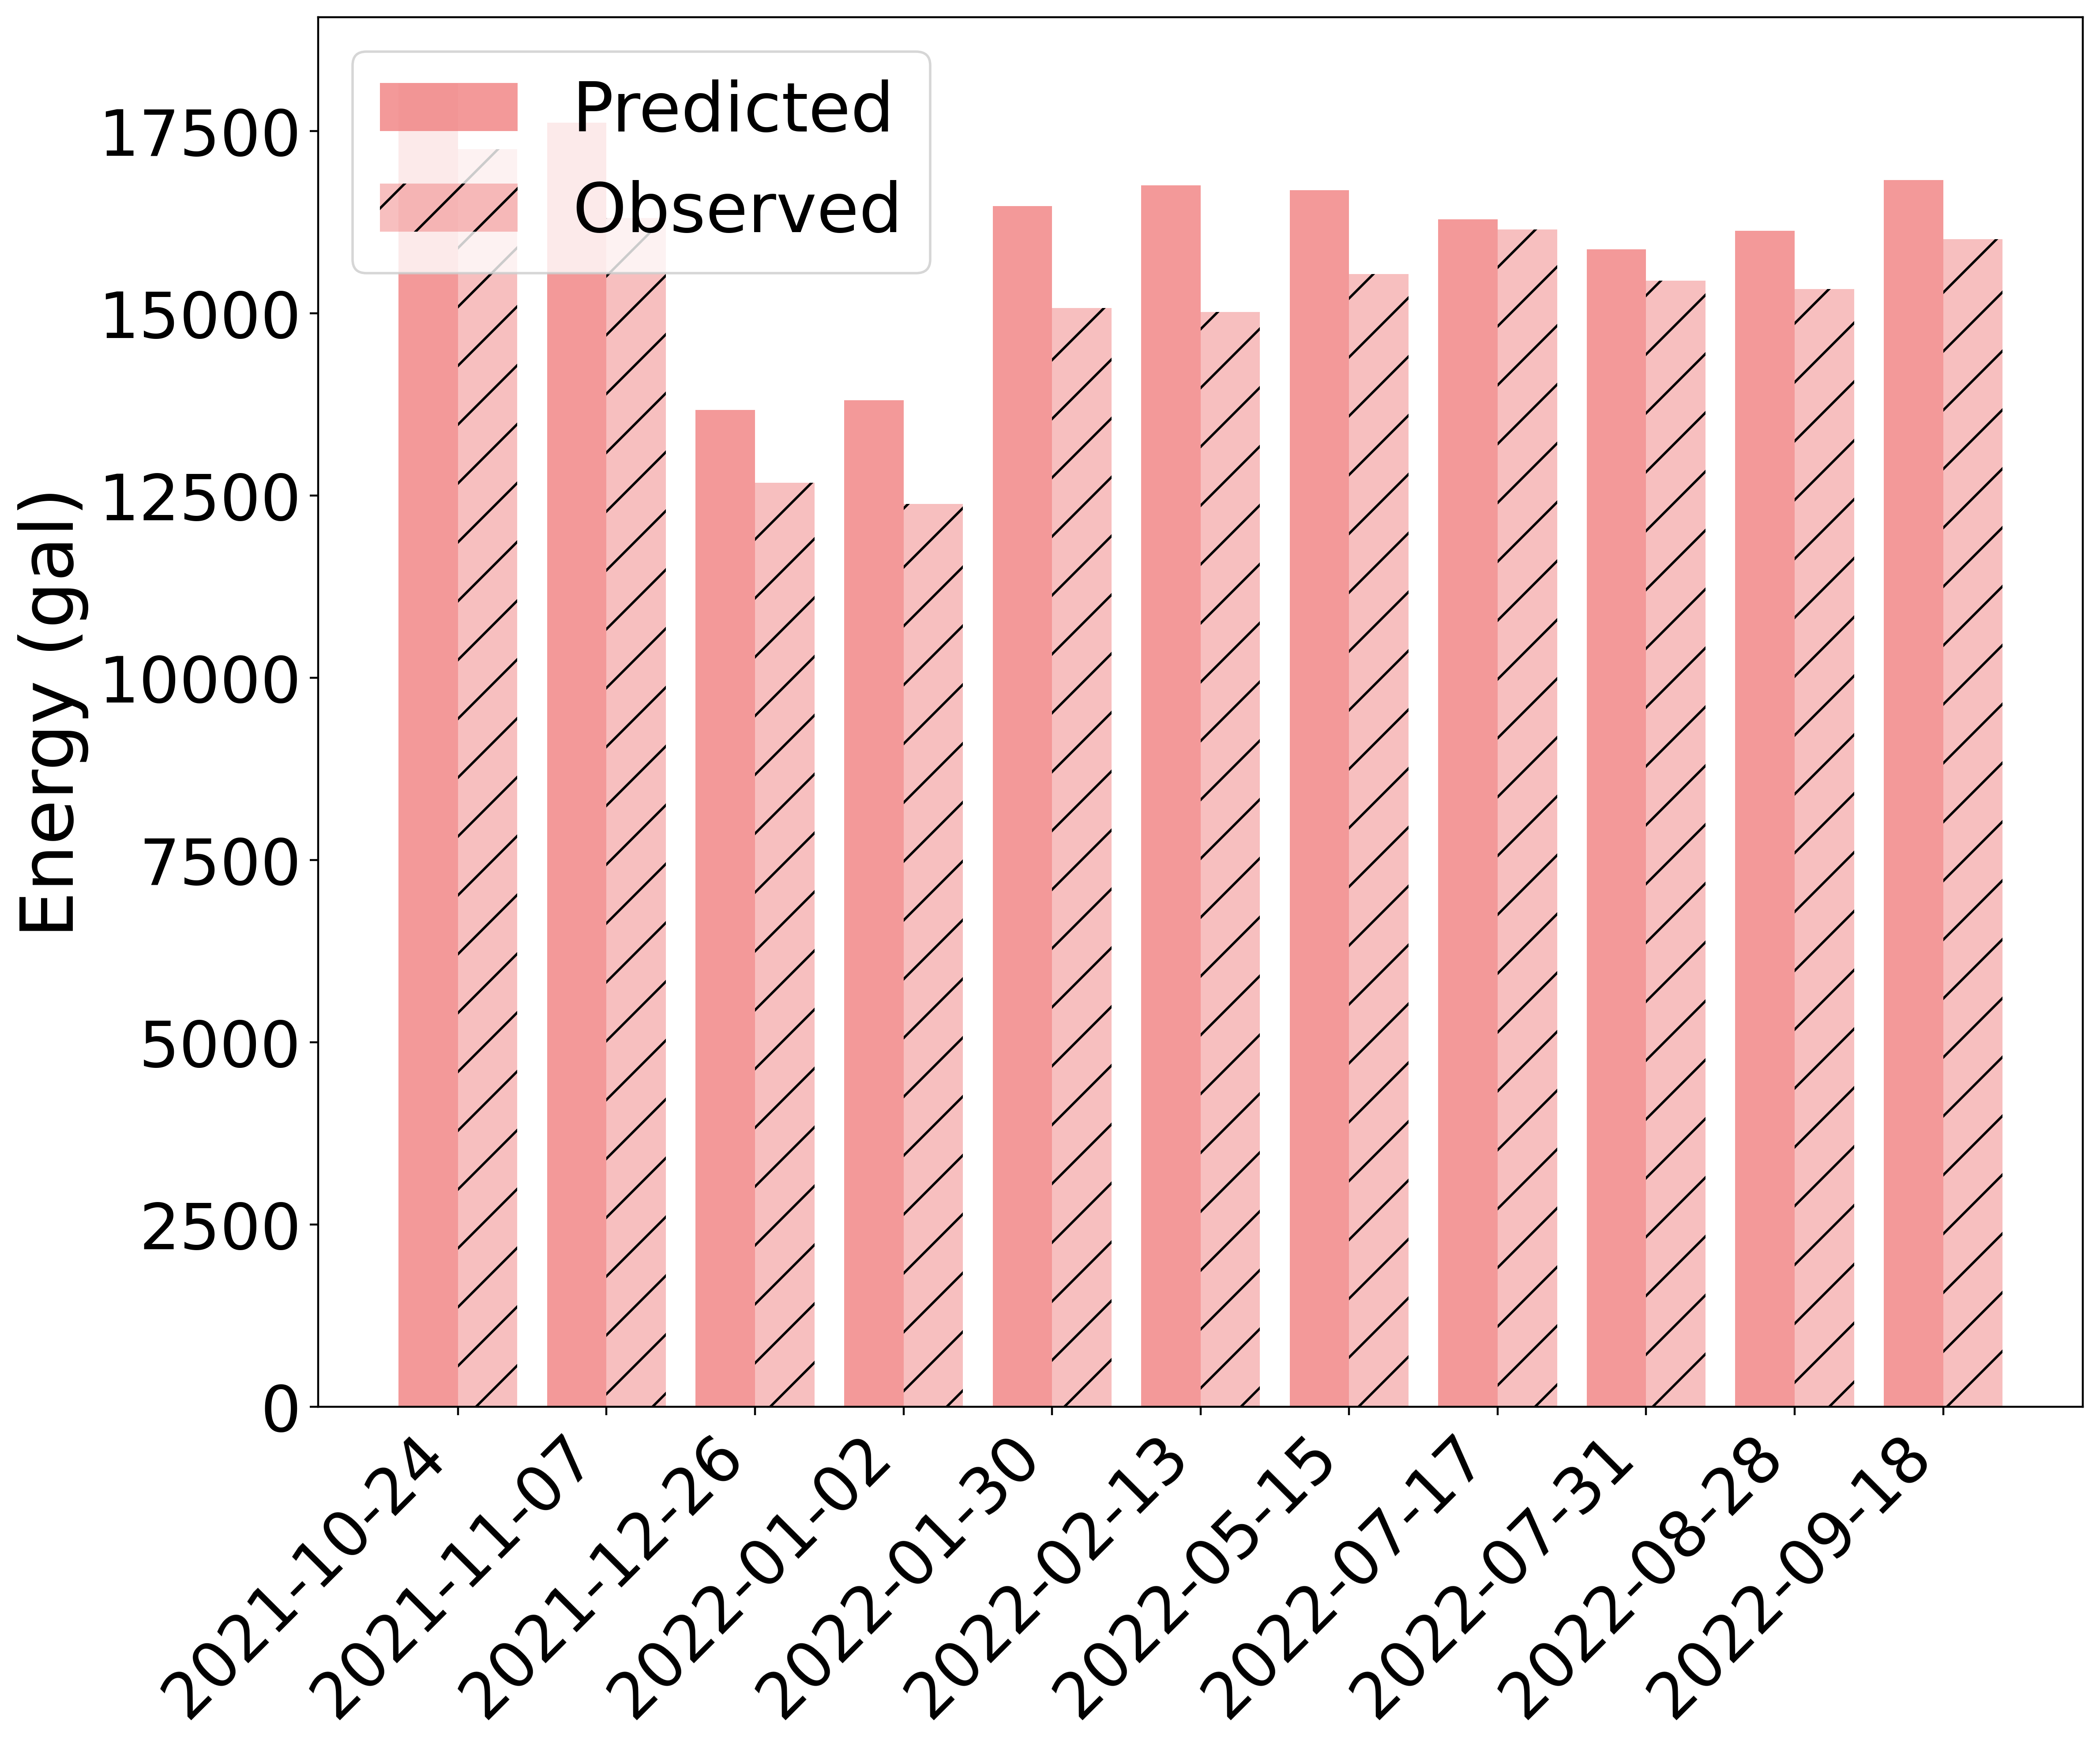

In [101]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure 'ServiceDateTime' is a datetime object
test_df_cdb_system['ServiceDateTime'] = pd.to_datetime(test_df_cdb_system['ServiceDateTime'])
test_df_cdb_system = test_df_cdb_system.sort_values('ServiceDateTime')


# Set 'ServiceDateTime' as index for plotting purposes
test_df_cdb_system.set_index('ServiceDateTime', inplace=True)

# Create an array with the position of each bar along the x-axis
x = np.arange(len(test_df_cdb_system))

# Set the width of the bars
bar_width = 0.4

plt.figure(figsize=(12, 10), dpi=400)

# Plot 'Predicted' bars
plt.bar(x - bar_width/2, test_df_cdb_system['Energy'], width=bar_width, color='lightcoral', alpha=0.8, label='Predicted')

# Plot 'Observed' bars
plt.bar(x + bar_width/2, test_df_cdb_system['Qty'], width=bar_width, color='lightcoral', alpha=0.5, hatch='/', label='Observed')

# Put the x-axis labels (ServiceDateTime) using the index values
plt.xticks(x, test_df_cdb_system.index.strftime('%Y-%m-%d'), rotation=45, ha='right', fontsize=26)
plt.yticks(fontsize=26)


plt.ylabel('Energy (gal)', fontsize=30)
plt.legend(fontsize=28)
plt.tight_layout() 

# Save the figure with high resolution
plt.savefig(r'../../figures/validation-CDB-Oct2021-Sep2022.png', dpi=400, bbox_inches='tight')
plt.show()
